## II. Programming and critical analysis

Consider the rent.csv dataset (available at the course’s webpage), where the goal is to predict the price of rents based on location features and house measurements. 
To answer question 5), average the performance of the models using 5-fold cross validation

5. Train a Linear Regression model, an MLP Regressor with 2 hidden layers of 5 neurons
each and no activation functions, and another MLP Regressor with 2 hidden layers of 5
neurons each using relu activation functions. Plot a boxplot of the test MAE of each model.

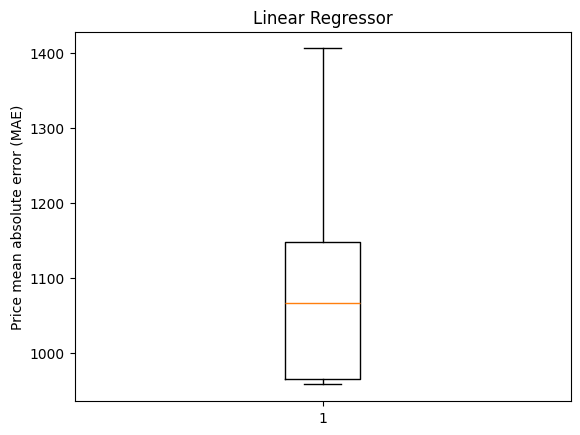

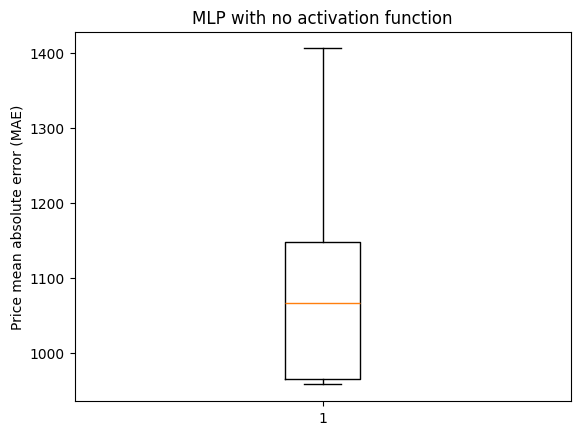

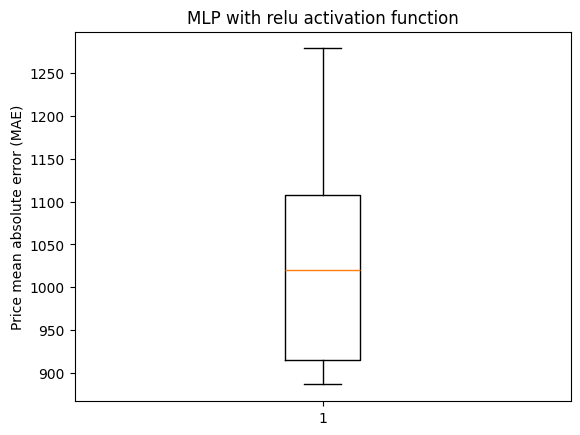

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

dados = pd.read_csv('rent.csv')
scaler = StandardScaler()
factors = dados.drop(['price','interest_level'], axis=1)    # drop interest_level as well because it is not a location nor a house measurement feature
factors_scaled = scaler.fit_transform(factors)
prices = dados['price']


MAEs = {
    'linear': [],
    'no_act': [],
    'relu': []
}


linear_reg = LinearRegression()

# For the MLPs, the models were not converging and finishing training on its own with gradient descent solvers
# like sgd and adam, so to get the best predictions we opted for lbfgs, with which the MLPs were able to converge

# 2 layers, 5 neurons in each, no activation function -> identity function f(x) = x
mlp_no_act = MLPRegressor(hidden_layer_sizes=(5,5), activation='identity', solver='lbfgs', max_iter=1000)
# 2 layers, 5 neurons in each, relu activation function
mlp_relu = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu', solver='lbfgs', max_iter=1000)


k_fold = KFold(n_splits=5)

for i_train, i_test in k_fold.split(factors_scaled, prices):
    factors_train, factors_test = factors_scaled[i_train], factors_scaled[i_test]
    prices_train, prices_test = prices[i_train], prices[i_test]
    
    
    # Linear regressor
    linear_reg.fit(factors_train, prices_train)
    prices_test_predicted = linear_reg.predict(factors_test)
    mae = mean_absolute_error(prices_test, prices_test_predicted)
    MAEs['linear'].append(mae)
    
    # MLP Regressor with no activation function
    mlp_no_act.fit(factors_train, prices_train)
    prices_test_predicted = mlp_no_act.predict(factors_test)
    mae = mean_absolute_error(prices_test, prices_test_predicted)
    MAEs['no_act'].append(mae)
    
    # MLP Regressor with relu activation function
    mlp_relu.fit(factors_train, prices_train)
    prices_test_predicted = mlp_relu.predict(factors_test)
    mae = mean_absolute_error(prices_test, prices_test_predicted)
    MAEs['relu'].append(mae)
    


    
plt.figure()
plt.boxplot(MAEs['linear'])
plt.title("Linear Regressor")
plt.ylabel("Price mean absolute error (MAE)")

plt.figure()
plt.boxplot(MAEs['no_act'])
plt.title("MLP with no activation function")
plt.ylabel("Price mean absolute error (MAE)")

plt.figure()
plt.boxplot(MAEs['relu'])
plt.title("MLP with relu activation function")
plt.ylabel("Price mean absolute error (MAE)")

plt.show()

6. Compare a Linear Regression with a MLP with relu activation, and explain the impact and the importance of using activation functions in a MLP. Support your reasoning with the results from the boxplots.

While a linear regression model can only establish patterns based on linear relationships between features and target variables, and thus can only distinguish data that is linearly separable, a multilayer perceptron (MLP) with  an adequate activation function can distinguish non linearly separable data, which makes it much more powerful. A MLP can model more complex patterns across features and achieve better predictions and generalization ability.

It is important to have a good activation function in the MLP and there are several properties that the function may or may not satisfy that will influence the model's performance. The most significant property, however, is the non-linear nature of the function because without this the model will just behave linearly, turning the entire network equivalent to a single layer model. In this case we won't be making use of the model's full potential and we will essentially just be using linear regression.

This can be seen by looking at the first and second boxplots, that show the mean absolute error for the linear regression model and for a MLP with the identity function (f(x) = x) as its activation function. It is clear that these boxplots are identical and that, when we compare them to the third one, where a ReLU activation function was used in the MLP, the median for the MAE on this model is lower, which indicates a higher accuracy.

Even though the third boxplot seems to have a wider spread of MAE, which could indicate some inconsistency across folds and poorer generalization ability, it is important to note that the third quartile in the third boxplot is already almost the same as the second quartile in the other boxplots, supporting our conclusion that the MLP with the ReLU activation function performs much better and is clearly a better choice over a linear model.


7. With a MLP with relu activation, plot the loss function for each training iteration for both the training and validation set. Take the average across different folds. Compare the results and explain whether the model is overfitting, underfitting, or has good generalization.

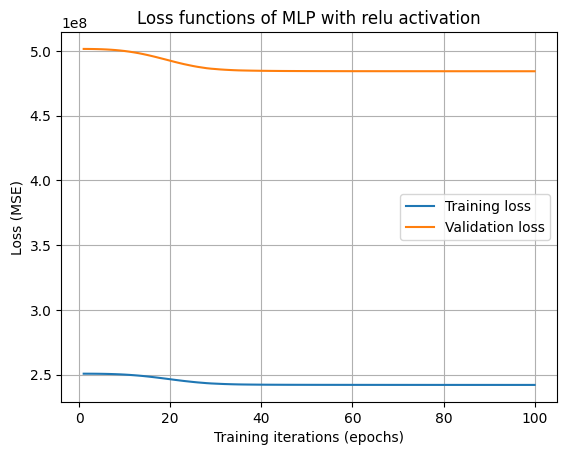

In [20]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning

dados = pd.read_csv('rent.csv')
scaler = StandardScaler()
factors = dados.drop(['price','interest_level'], axis=1)    # drop interest_level as well because it is not a location nor a house measurement feature
factors_scaled = scaler.fit_transform(factors)
prices = dados['price']


# total training iterations, aka epochs, that we will train the model for
total_training_iterations = 100

k_fold = KFold(n_splits=5)

# loss per fold, each element will be a list that corresponds to a fold
training_losses_per_fold = []
validation_losses_per_fold = []

avg_training_losses = []
avg_validation_losses = []

for i_train, i_val in k_fold.split(factors_scaled, prices):
    factors_train, factors_val = factors_scaled[i_train], factors_scaled[i_val]
    prices_train, prices_val = prices[i_train], prices[i_val]
    
    # We only allow the MLP to train for 1 iteration (epoch) so we can evaluate the errors, but we make it have a
    # warm start so in the next epoch it picks up from where it left off
    mlp_relu = MLPRegressor(hidden_layer_sizes=(5,5),
                           activation='relu',
                           solver='adam',
                           max_iter=1,
                           warm_start=True)
    
    training_losses = []
    validation_losses = []
    
    
    for t_iter in range(total_training_iterations):
        # The model will throw a warning since it won't converge with only one iteration (and even with several it won't)
        # since this is expected behaviour we just suppress this specific warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            # Train the model
            mlp_relu.fit(factors_train, prices_train)
        
        training_losses.append(mlp_relu.loss_)
        
        prices_val_predicted = mlp_relu.predict(factors_val)
        # Defaut loss function for the model is squared error (MSE) so to compare training and validation losses
        # we also calculate the validation loss with squared error
        val_loss = mean_squared_error(prices_val, prices_val_predicted)
        validation_losses.append(val_loss)
        
    
    training_losses_per_fold.append(training_losses)
    validation_losses_per_fold.append(validation_losses)

    

    
# losses_per_iteration will be (loss_1st_fold, loss_2nd_fold, ...) all belong to the same training iteration
for losses_per_iteration in zip(*training_losses_per_fold):
    avg = sum(losses_per_iteration) / len(losses_per_iteration)
    avg_training_losses.append(avg)


for losses_per_iteration in zip(*validation_losses_per_fold):
    avg = sum(losses_per_iteration) / len(losses_per_iteration)
    avg_validation_losses.append(avg)

        

plt.plot([i for i in range(1, total_training_iterations+1)], avg_training_losses, label="Training loss")
plt.plot([i for i in range(1, total_training_iterations+1)], avg_validation_losses, label="Validation loss")
plt.legend()
plt.title("Loss functions of MLP with relu activation")
plt.xlabel("Training iterations (epochs)")
plt.ylabel("Loss (MSE)")
plt.grid(True)


plt.show()

By looking at the graphs we can see a decrease in both losses as the model goes through more training iterations, although they stabilize after a certain epoch. However, what's important to note in these graphs is how distant the training loss graph is from the validation loss graph. The mean squared error in the validation set is significantly higher than the mean squared error for the training set.

This is a clear example of overfitting, since the error is much greater when the model attempts to generalize predictions for data it has not seen before. This happens because the model is too used to its training data and fits this data too much, which hinders its ability to generalize.